In [40]:
# import json
# import geojson
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score

In [41]:
# with open('intermediate_file_paths.json') as output_path_file:
#     output_paths = json.load(output_path_file)

# SI_PER_FIRE_INPUT_PATH = output_paths.get('stage1_si_per_fire_csv')
# SCALED_SI_PER_YEAR_INPUT_PATH = output_paths.get('stage2_scaled_si_per_year_csv')

# # Load dataset
# yearly_smoke_impact_df = pd.read_csv(SCALED_SI_PER_YEAR_INPUT_PATH)
# si_per_fire_df = pd.read_csv(SI_PER_FIRE_INPUT_PATH)

In [42]:
# print(yearly_smoke_impact_df.columns)

In [43]:
# print(si_per_fire_df.columns)

Years with NaN values: [2021]
Cross-Validation Mean Squared Error (MSE): 138.35630263790412
Cross-Validation R-squared (R2): -0.14047975353451742
Mean Squared Error (MSE) for 1984-2021: 233.1588144734887
R-squared (R2) Score for 1984-2021: -1.6869717388597434


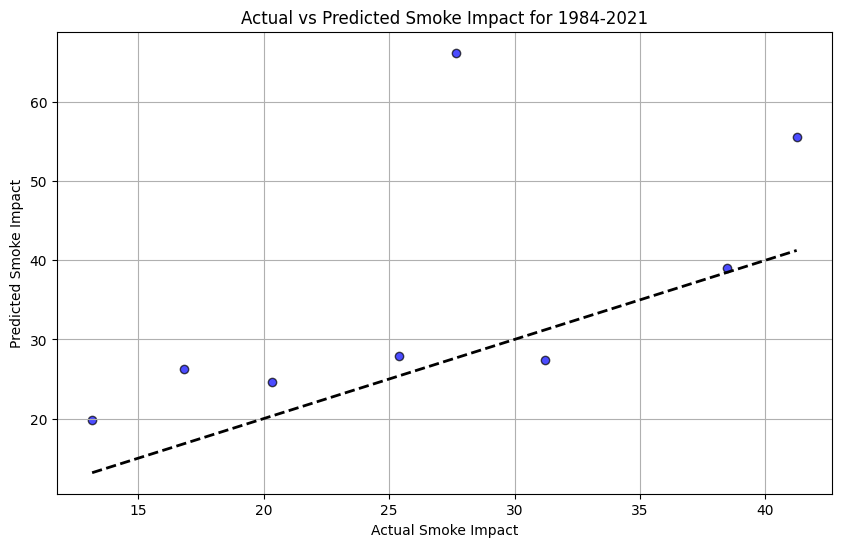

In [44]:
# %% [markdown]
# ## Update to include info about calculation steps

# %%
import json
import geojson
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

with open('intermediate_file_paths.json') as output_path_file:
    output_paths = json.load(output_path_file)

SI_PER_FIRE_INPUT_PATH = output_paths.get('stage1_si_per_fire_csv')
SCALED_SI_PER_YEAR_INPUT_PATH = output_paths.get('stage2_scaled_si_per_year_csv')

# Load dataset
yearly_smoke_impact_df = pd.read_csv(SCALED_SI_PER_YEAR_INPUT_PATH)
si_per_fire_df = pd.read_csv(SI_PER_FIRE_INPUT_PATH)

# Define weights for 'total_acres_burned' and 'distance'
weights = {'total_acres_burned': 0.7, 'distance': 0.3}

# Calculate the average distance per year
avg_dist_df = si_per_fire_df.groupby('fire_year').agg(
    avg_dist_from_city=('distance', 'mean')
).reset_index()

# Filter data to include only years after 1984
yearly_smoke_impact_filtered_df = yearly_smoke_impact_df[yearly_smoke_impact_df['year'] > 1984]
filtered_avg_dist_df = avg_dist_df[avg_dist_df['fire_year'] > 1984]

# Prepare data for prediction using original data (without moving average)
combined_df = yearly_smoke_impact_filtered_df[['scaled_avg_daily_smoke_impact', 'year', 'total_acres_burned']].merge(
    filtered_avg_dist_df[['fire_year', 'avg_dist_from_city']],
    left_on='year', right_on='fire_year', how='left'
)

# Apply weights to the relevant predictor variables
combined_df['total_acres_burned_weighted'] = combined_df['total_acres_burned'] * weights['total_acres_burned']
combined_df['distance_weighted'] = combined_df['avg_dist_from_city'] * weights['distance']

# Identify which years have NaN values
na_years = combined_df[combined_df.isna().any(axis=1)]['year'].unique()
print(f"Years with NaN values: {na_years}")

# Remove rows with NaN values in features or labels
combined_df = combined_df.dropna()

# Prepare the features and target variable
features = combined_df[['total_acres_burned_weighted', 'distance_weighted']]
labels = combined_df['scaled_avg_daily_smoke_impact'].values

# Add interaction terms using PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
features_interaction = poly.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_interaction, labels, test_size=0.2, random_state=42)

# Create and train the linear regression model with K-Fold Cross-Validation
model = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_mse = cross_val_score(model, features_interaction, labels, cv=kf, scoring='neg_mean_squared_error')
cross_val_r2 = cross_val_score(model, features_interaction, labels, cv=kf, scoring='r2')

print(f"Cross-Validation Mean Squared Error (MSE): {-np.mean(cross_val_mse)}")
print(f"Cross-Validation R-squared (R2): {np.mean(cross_val_r2)}")

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict smoke estimates for the test set
y_pred = model.predict(X_test)

# Calculate metrics for model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE) for 1984-2021: {mse}")
print(f"R-squared (R2) Score for 1984-2021: {r2}")

# Plotting the actual vs predicted smoke impact for the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Smoke Impact')
plt.ylabel('Predicted Smoke Impact')
plt.title('Actual vs Predicted Smoke Impact for 1984-2021')
plt.grid(True)
plt.show()

